<a href="https://colab.research.google.com/github/subaru9/ml-notebooks/blob/main/cv/classification/rd-fp-planes-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# Dataset

This is a subset of military air planes [dataset](https://www.kaggle.com/datasets/a2015003713/militaryaircraftdetectiondataset) representing russian aircrafts as well as one sample of US plane. The images cropped from the original dataset images according to the bounding box annotations and is specifically prepared to facilitate the easy training of classification models.

In [ ]:
from google.colab import drive
drive.mount('/content/drive');

dataset_folder = "/content/drive/MyDrive/Colab Notebooks/dataset/military-air-planes"

Mounted at /content/drive


In [ ]:
if os.path.exists(dataset_folder):
    files_in_directory = os.listdir(dataset_folder)
    if files_in_directory == ['mil-planes.tar.gz']:
        os.chdir(dataset_folder)
        !tar -xzf mil-planes.tar.gz && echo "Extraction successful. Files have been unpacked."
    else:
        print("The directory contains files other than 'mil-planes.tar.gz'. Extraction skipped.")
else:
    print(f"Directory {dataset_folder} does not exist.")

The directory contains files other than 'mil-planes.tar.gz'. Extraction skipped.


## Data Inspection

In [ ]:
path = os.path.join(dataset_folder, 'mil-planes.csv')
df = pd.read_csv(path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3384 entries, 0 to 3383
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   path      3384 non-null   object
 1   category  3384 non-null   object
 2   class_id  3384 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 79.4+ KB


In [ ]:
df.head()

,path,category,class_id
0,6b2f847b63922d79120334329c0ca396_1.jpg,tu95,0
1,c49d9a8f5a26485ba0bdd0fa4c32ab9b_0.jpg,tu95,0
2,953a151c55c845dfd28658f43e8d3976_0.jpg,tu95,0
3,27ee17e2c031ca3c0cf5553b6c0b52f0_1.jpg,tu95,0
4,8dcc17cbd5ec25df1c64990a6b130695_2.jpg,tu95,0


In [ ]:
df.tail()

,path,category,class_id
3379,4573b545f600572b60d2bd35fbf61a03_1.jpg,f16,7
3380,efd8a5bd1d03a71d4db28e313a3f62ce_1.jpg,f16,7
3381,f164b6193b9d4f3ecf8c8e0f234ce066_3.jpg,f16,7
3382,c7ec7b660ede88aca9a63f90ae531806_5.jpg,f16,7
3383,4fa8bb46e75938624bfc50233c29c3ff_1.jpg,f16,7


In [ ]:
df.category.describe()

count     3384
unique       8
top        f16
freq      1366
Name: category, dtype: object

f16 is the most frequent category with almost the half of the planes, looks like dataset is imbalanced

In [ ]:
num_samples = len(df)

### Visualization

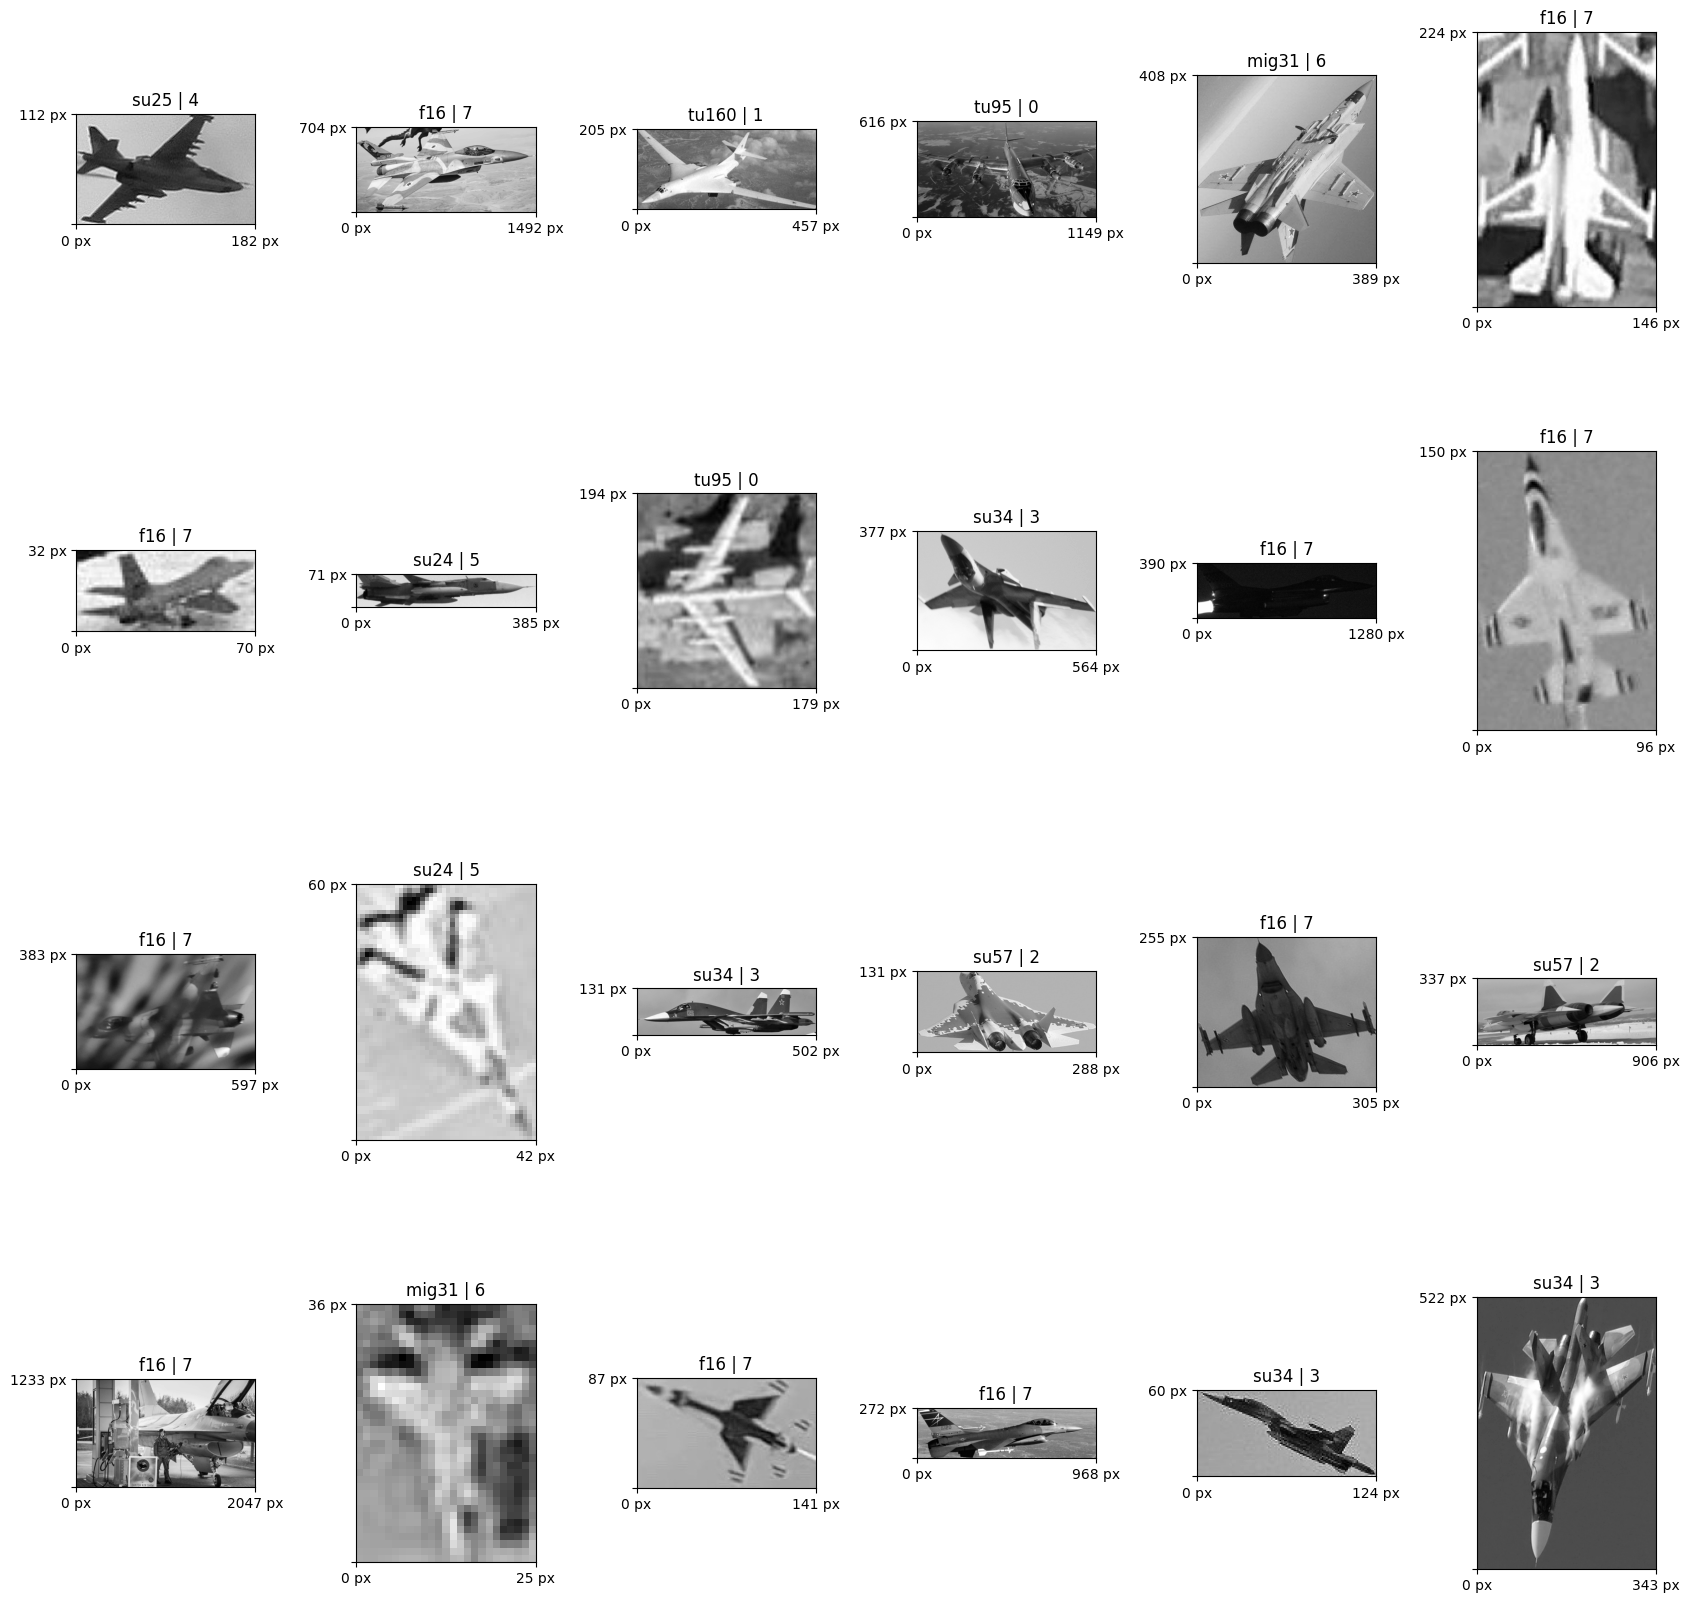

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(17, 17))

for i, ax in enumerate(axes.flat):
    idx = np.random.randint(0, num_samples)
    row = df.iloc[idx]

    class_id = row['class_id']
    class_name = row['category']
    ax.set_title(class_name + " | " + str(class_id))

    path = os.path.join(dataset_folder, row['path'])
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ax.imshow(img, cmap='gray', extent=[0, img.shape[1], 0, img.shape[0]])

    # set coordinates to start from left bottom corner
    ax.set_xticks([0, img.shape[1]])
    ax.set_yticks([0, img.shape[0]])

    # set lables for axis in px
    ax.set_xticklabels(['0 px', f'{img.shape[1]} px'])
    ax.set_yticklabels(['', f'{img.shape[0]} px'])

plt.tight_layout()
plt.show()

Counter({'f16': 1366, 'su34': 381, 'mig31': 375, 'su57': 329, 'tu160': 278, 'tu95': 271, 'su24': 221, 'su25': 163})


(Text(0.5, 0, 'category'), Text(0, 0.5, 'count'))

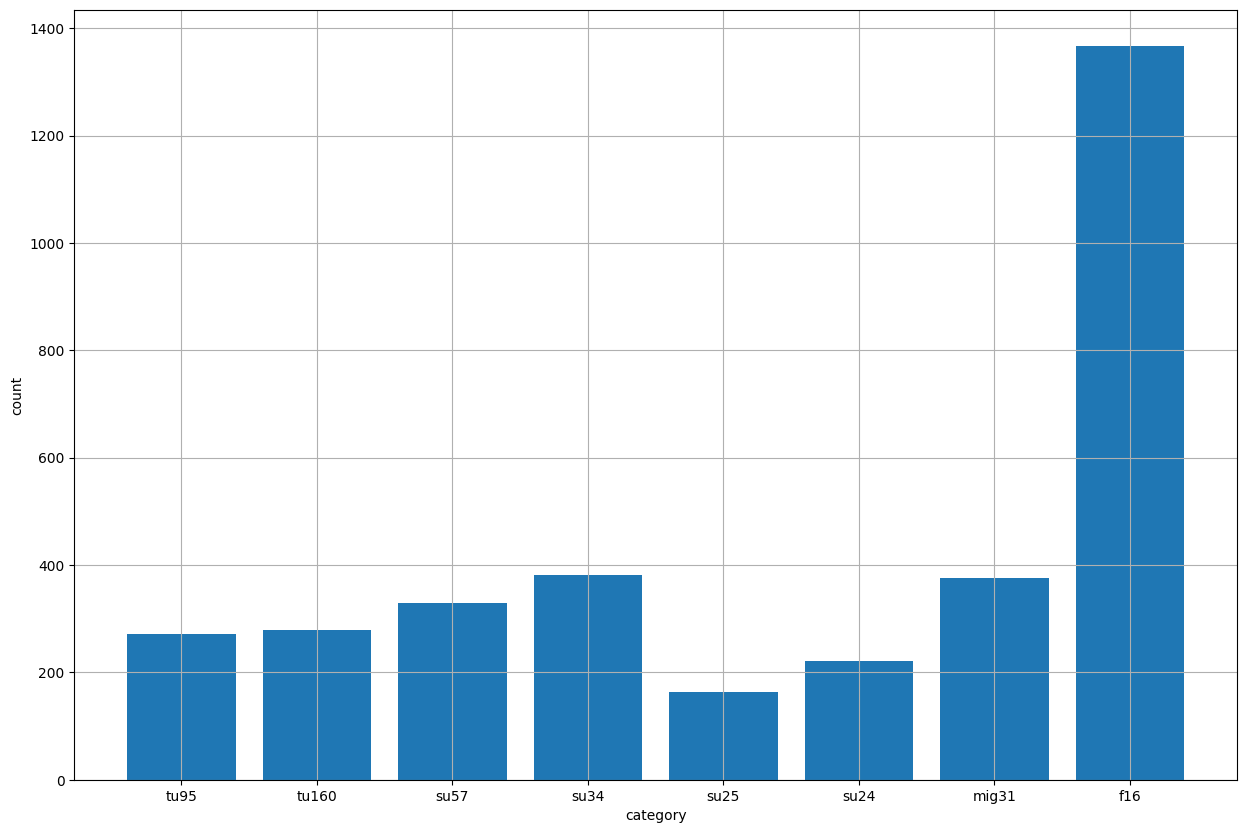

In [ ]:
from collections import Counter
hist = Counter(df['category'])
print(hist)

plt.bar(hist.keys(), hist.values()), plt.grid(True)
plt.xlabel('category'), plt.ylabel('count')

In [ ]:
# def calculate_brightness(image_path):
#     image = cv2.imread(image_path)
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     return np.mean(gray)

# brightness_per_class = {}
# class_ids = df['class_id'].unique()
# for class_id in class_ids:
#     current_class_filter = df['class_id'] == class_id
#     paths = df[current_class_filter]['path']
#     brightnesses = [calculate_brightness(os.path.join(dataset_folder, path)) for path in paths]
#     brightness_per_class[class_id] = np.mean(brightnesses)

In [ ]:
# plt.bar(brightness_per_class.keys(), brightness_per_class.values()), plt.grid(True)
# plt.xlabel('Classes ID'), plt.ylabel('Brightness')

## Data preparation

In [ ]:
def calculate_average_image_size(df, dataset_folder):
    sizes = []  # Список для зберігання розмірів усіх зображень

    for path in df['path']:
        image_path = os.path.join(dataset_folder, path)
        image = cv2.imread(image_path)
        if image is not None:
            sizes.append(image.shape[1:])  # Додаємо кортеж (ширина, висота)

    # Розраховуємо середні значення ширини та висоти
    average_width = np.mean([size[0] for size in sizes])
    average_height = np.mean([size[1] for size in sizes])

    return average_width, average_height


average_width, average_height = calculate_average_image_size(df, dataset_folder)
print(f"Середня ширина: {average_width}, Середня висота: {average_height}")


Середня ширина: 608.6852836879433, Середня висота: 3.0


In [ ]:
from sklearn.model_selection import train_test_split

train_valid_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_df, valid_df = train_test_split(train_valid_df, test_size=0.25, random_state=42)

print(f"Total dataset size: {df.shape[0]}")
print(f"Train dataset size: {train_df.shape[0]}")
print(f"Validation dataset size: {valid_df.shape[0]}")
print(f"Test dataset size: {test_df.shape[0]}")


Total dataset size: 3384
Train dataset size: 2030
Validation dataset size: 677
Test dataset size: 677


To address the dataset's challenges, we will implement several strategies dynamically during the training phase:

- **Adjust Image Sizes Dynamically**: Images will be resized to a uniform size in real-time during the training process, ensuring consistent input dimensions.
- **Apply Data Augmentation On-the-fly**: Various image transformations, such as rotations, scaling, and flipping, will be dynamically applied to enrich the dataset and improve the model's ability to generalize.
- **Dynamically Adjust Class Weights**: To mitigate class imbalance, class weights will be modified in real-time, prioritizing underrepresented classes during training.
- **Dynamical Image normalization**
- **Dynamic one-hot-encoding for lables**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Валідаційний набір, як правило, не потребує аугментації, але має бути нормалізований
valid_datagen = ImageDataGenerator(rescale=1./255)

# Тестовий набір
test_datagen = ImageDataGenerator(rescale=1./255)

# Створення генераторів для тренувального, валідаційного і тестового наборів
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='path_to_images',
    x_col='path',
    y_col='category',
    target_size=(224, 224),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory='path_to_images',
    x_col='path',
    y_col='category',
    target_size=(224, 224),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=False  # Важливо для валідаційного набору, щоб зберігати порядок для оцінки
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='path_to_images',
    x_col='path',
    y_col='category',
    target_size=(224, 224),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=False  # Аналогічно, важливо не перемішувати тестовий набір
)
